<div style="margin-bottom: 32px;">
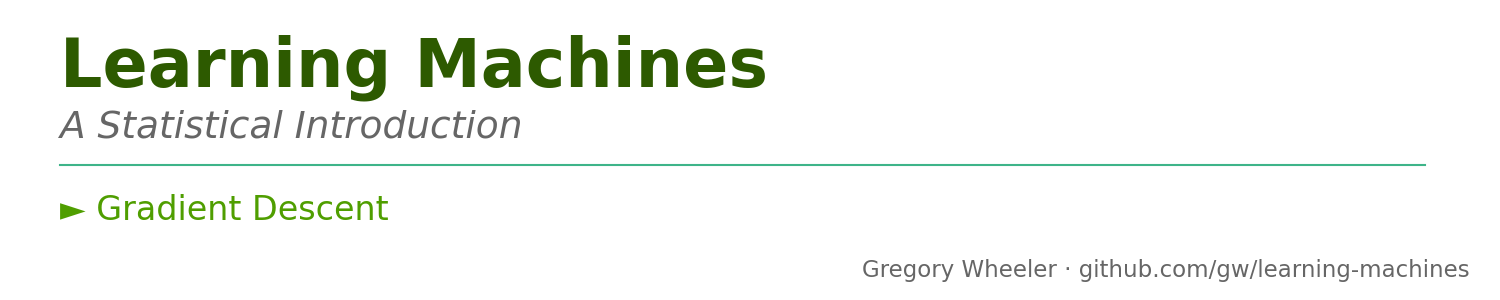
</div>


# Gradient Descent: Making Optimization Geometric

Gradient descent is the workhorse of machine learning optimization. This notebook makes the algorithm visual: we see contours, trajectories, and the effect of hyperparameters on convergence.

**What computation adds**: The text provides the algorithm and analyzes convergence. Here we watch the algorithm "walk" toward the minimum, observe overshooting with large learning rates, and crawling with small ones.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from pathlib import Path
import sys

# Add notebook directory to path for imports
sys.path.insert(0, str(Path.cwd()))

# Import and apply our theme
import mlone_theme as mt
plt.style.use('mlone_style.mplstyle')
mt.set_notebook_mode()  # Green-primary palette for notebooks

## 1. The Setup: Linear Regression Loss Surface

We consider simple linear regression: $\hat{y} = \beta_0 + \beta_1 x$. The loss function is mean squared error:

$$L(\beta_0, \beta_1) = \frac{1}{n}\sum_{i=1}^{n}(y_i - \beta_0 - \beta_1 x_i)^2$$

This is a quadratic function of $(\beta_0, \beta_1)$, so its contours are ellipses centered at the optimal solution.

In [2]:
# Generate simple linear data
np.random.seed(42)
n = 30
x = np.random.uniform(-2, 2, n)
true_beta0, true_beta1 = 1.0, 2.0  # True parameters
y = true_beta0 + true_beta1 * x + np.random.normal(0, 0.5, n)

# Compute OLS solution (the target of gradient descent)
X = np.column_stack([np.ones(n), x])
beta_ols = np.linalg.lstsq(X, y, rcond=None)[0]
print(f"True parameters: β₀ = {true_beta0:.2f}, β₁ = {true_beta1:.2f}")
print(f"OLS solution:    β₀ = {beta_ols[0]:.2f}, β₁ = {beta_ols[1]:.2f}")

True parameters: β₀ = 1.00, β₁ = 2.00
OLS solution:    β₀ = 0.87, β₁ = 1.83


In [3]:
def mse_loss(beta0, beta1, x, y):
    """Compute MSE loss for given parameters."""
    predictions = beta0 + beta1 * x
    return np.mean((y - predictions)**2)

def gradient(beta0, beta1, x, y):
    """Compute gradient of MSE loss."""
    predictions = beta0 + beta1 * x
    residuals = predictions - y
    grad_beta0 = 2 * np.mean(residuals)
    grad_beta1 = 2 * np.mean(residuals * x)
    return np.array([grad_beta0, grad_beta1])

In [4]:
# Create loss surface for visualization
beta0_range = np.linspace(-1, 3, 100)
beta1_range = np.linspace(0, 4, 100)
B0, B1 = np.meshgrid(beta0_range, beta1_range)

# Compute loss at each point
Loss = np.zeros_like(B0)
for i in range(B0.shape[0]):
    for j in range(B0.shape[1]):
        Loss[i, j] = mse_loss(B0[i, j], B1[i, j], x, y)

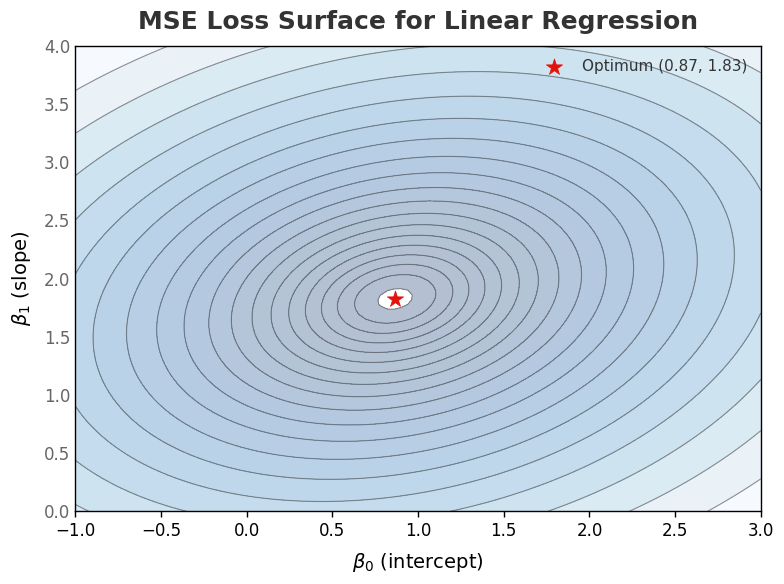

In [5]:
# Visualize the loss surface
fig, ax = plt.subplots(figsize=(8, 6))

# Contour plot
levels = np.logspace(np.log10(Loss.min() + 0.01), np.log10(Loss.max()), 20)
cs = ax.contour(B0, B1, Loss, levels=levels, colors=mt.GRAY, linewidths=0.8, alpha=0.7)
ax.contourf(B0, B1, Loss, levels=levels, cmap='Blues_r', alpha=0.3)

# Mark the optimum
ax.scatter(*beta_ols, color=mt.RED, s=150, marker='*', zorder=5, 
           label=f'Optimum ({beta_ols[0]:.2f}, {beta_ols[1]:.2f})')

ax.set_xlabel(r'$\beta_0$ (intercept)')
ax.set_ylabel(r'$\beta_1$ (slope)')
ax.set_title('MSE Loss Surface for Linear Regression')
ax.legend(loc='upper right')

# Style adjustments for this type of plot
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
for spine in ax.spines.values():
    spine.set_color('black')
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False)
ax.grid(False)

plt.tight_layout()
plt.show()

## 2. Gradient Descent Algorithm

The gradient descent update rule is:

$$\boldsymbol{\beta}^{(t+1)} = \boldsymbol{\beta}^{(t)} - \eta \nabla L(\boldsymbol{\beta}^{(t)})$$

where $\eta$ is the **learning rate** (step size). The gradient points "uphill"; we move in the opposite direction.

In [6]:
def gradient_descent(x, y, learning_rate, n_iterations, beta_init):
    """
    Run gradient descent for linear regression.
    
    Returns:
        history: list of (beta0, beta1) at each iteration
        losses: list of loss values at each iteration
    """
    beta = np.array(beta_init, dtype=float)
    history = [beta.copy()]
    losses = [mse_loss(beta[0], beta[1], x, y)]
    
    for _ in range(n_iterations):
        grad = gradient(beta[0], beta[1], x, y)
        beta = beta - learning_rate * grad
        history.append(beta.copy())
        losses.append(mse_loss(beta[0], beta[1], x, y))
    
    return np.array(history), np.array(losses)

## 3. The Effect of Learning Rate

The learning rate $\eta$ critically affects convergence:
- **Too small**: Slow convergence, many iterations needed
- **Too large**: Overshooting, oscillation, or divergence
- **Just right**: Fast, stable convergence

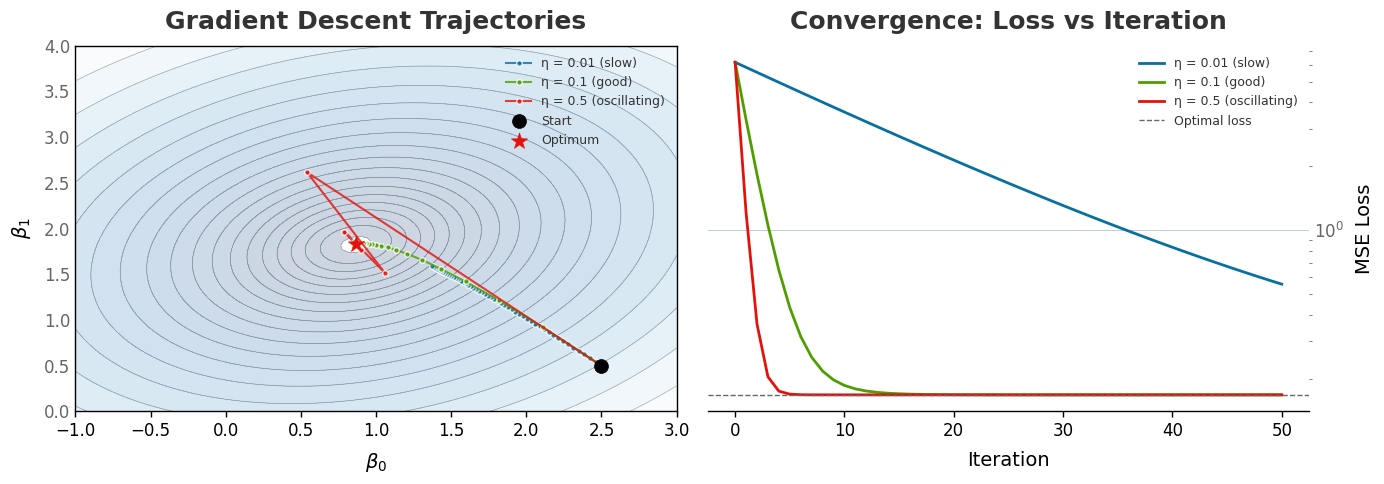

In [7]:
# Compare different learning rates
beta_init = [2.5, 0.5]  # Starting point
n_iter = 50

learning_rates = [0.01, 0.1, 0.5]
colors = [mt.BLUE, mt.GREEN, mt.RED]
labels = ['η = 0.01 (slow)', 'η = 0.1 (good)', 'η = 0.5 (oscillating)']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: trajectories on contour plot
ax1 = axes[0]
levels = np.logspace(np.log10(Loss.min() + 0.01), np.log10(Loss.max()), 20)
ax1.contour(B0, B1, Loss, levels=levels, colors=mt.GRAY, linewidths=0.5, alpha=0.5)
ax1.contourf(B0, B1, Loss, levels=levels, cmap='Blues_r', alpha=0.2)

for lr, color, label in zip(learning_rates, colors, labels):
    history, losses = gradient_descent(x, y, lr, n_iter, beta_init)
    ax1.plot(history[:, 0], history[:, 1], 'o-', color=color, markersize=4, 
             linewidth=1.5, label=label, alpha=0.8)

ax1.scatter(*beta_init, color='black', s=100, marker='o', zorder=5, label='Start')
ax1.scatter(*beta_ols, color=mt.RED, s=150, marker='*', zorder=5, label='Optimum')

ax1.set_xlabel(r'$\beta_0$')
ax1.set_ylabel(r'$\beta_1$')
ax1.set_title('Gradient Descent Trajectories')
ax1.legend(loc='upper right', fontsize=9)
ax1.set_xlim(-1, 3)
ax1.set_ylim(0, 4)

# Style
for spine in ['top', 'right', 'left', 'bottom']:
    ax1.spines[spine].set_visible(True)
    ax1.spines[spine].set_color('black')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position('left')
ax1.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False)
ax1.grid(False)

# Right panel: loss over iterations
ax2 = axes[1]
for lr, color, label in zip(learning_rates, colors, labels):
    history, losses = gradient_descent(x, y, lr, n_iter, beta_init)
    ax2.plot(range(len(losses)), losses, '-', color=color, linewidth=2, label=label)

ax2.axhline(y=mse_loss(*beta_ols, x, y), color=mt.GRAY, linestyle='--', 
            linewidth=1, label='Optimal loss')

ax2.set_xlabel('Iteration')
ax2.set_ylabel('MSE Loss')
ax2.set_title('Convergence: Loss vs Iteration')
ax2.legend(loc='upper right', fontsize=9)
ax2.set_yscale('log')

mt.apply_economist_style(ax2)

plt.tight_layout()
plt.show()

## 4. Divergence: Learning Rate Too Large

When the learning rate exceeds a critical threshold, gradient descent diverges: the loss increases instead of decreasing.

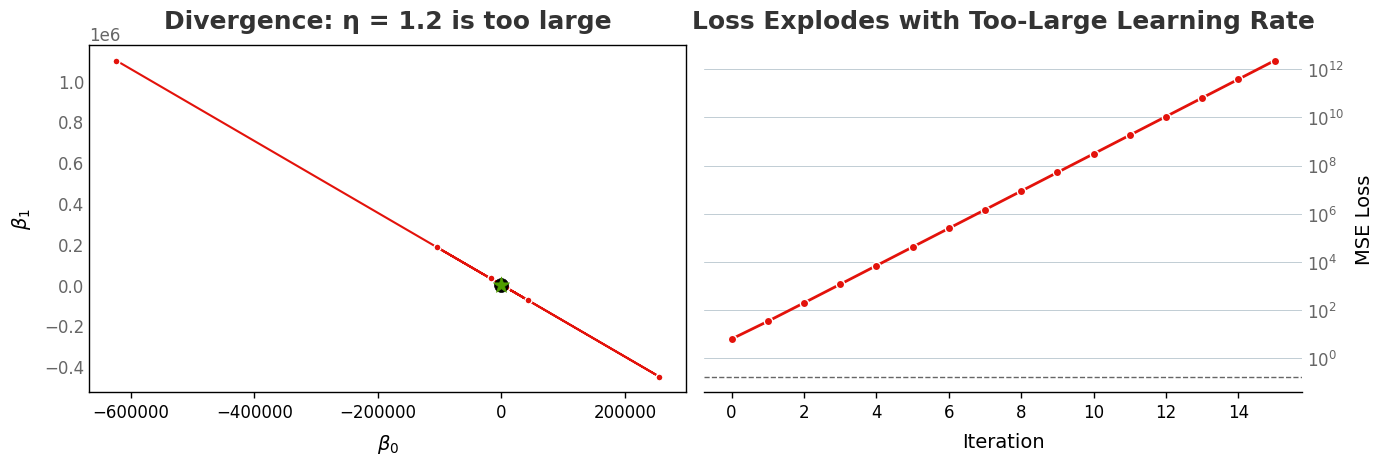

After 15 iterations with η=1.2: loss = 2.29e+12


In [8]:
# Show divergence with too-large learning rate
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Diverging trajectory
ax1 = axes[0]
lr_diverge = 1.2
history_div, losses_div = gradient_descent(x, y, lr_diverge, 15, beta_init)

# Wider view for divergence
b0_wide = np.linspace(-5, 8, 100)
b1_wide = np.linspace(-5, 10, 100)
B0_w, B1_w = np.meshgrid(b0_wide, b1_wide)
Loss_w = np.zeros_like(B0_w)
for i in range(B0_w.shape[0]):
    for j in range(B0_w.shape[1]):
        Loss_w[i, j] = mse_loss(B0_w[i, j], B1_w[i, j], x, y)

levels = np.logspace(0, 3, 15)
ax1.contour(B0_w, B1_w, Loss_w, levels=levels, colors=mt.GRAY, linewidths=0.5, alpha=0.5)
ax1.contourf(B0_w, B1_w, Loss_w, levels=levels, cmap='Reds_r', alpha=0.2)

ax1.plot(history_div[:, 0], history_div[:, 1], 'o-', color=mt.RED, markersize=5, 
         linewidth=1.5, label=f'η = {lr_diverge} (diverging)')
ax1.scatter(*beta_init, color='black', s=100, marker='o', zorder=5)
ax1.scatter(*beta_ols, color=mt.GREEN, s=150, marker='*', zorder=5)

ax1.set_xlabel(r'$\beta_0$')
ax1.set_ylabel(r'$\beta_1$')
ax1.set_title(f'Divergence: η = {lr_diverge} is too large')

for spine in ['top', 'right', 'left', 'bottom']:
    ax1.spines[spine].set_visible(True)
    ax1.spines[spine].set_color('black')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position('left')
ax1.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False)
ax1.grid(False)

# Loss curve showing explosion
ax2 = axes[1]
ax2.plot(range(len(losses_div)), losses_div, 'o-', color=mt.RED, linewidth=2, 
         markersize=6, label=f'η = {lr_diverge}')
ax2.axhline(y=mse_loss(*beta_ols, x, y), color=mt.GRAY, linestyle='--', linewidth=1)

ax2.set_xlabel('Iteration')
ax2.set_ylabel('MSE Loss')
ax2.set_title('Loss Explodes with Too-Large Learning Rate')
ax2.set_yscale('log')

mt.apply_economist_style(ax2)

plt.tight_layout()
plt.show()

print(f"After 15 iterations with η={lr_diverge}: loss = {losses_div[-1]:.2e}")

## 5. Stochastic Gradient Descent (SGD)

**Batch gradient descent** computes the gradient using all $n$ training examples. **Stochastic gradient descent** uses a random subset (mini-batch) at each step:

- Faster per-iteration (less computation)
- Noisier updates (introduces randomness)
- Can escape shallow local minima
- Requires smaller learning rate for stability

In [9]:
def sgd(x, y, learning_rate, n_iterations, beta_init, batch_size=1):
    """
    Stochastic gradient descent with mini-batches.
    
    batch_size=1: true SGD (one sample at a time)
    batch_size=n: equivalent to batch gradient descent
    """
    beta = np.array(beta_init, dtype=float)
    history = [beta.copy()]
    losses = [mse_loss(beta[0], beta[1], x, y)]
    n = len(x)
    
    for _ in range(n_iterations):
        # Random mini-batch
        idx = np.random.choice(n, size=batch_size, replace=False)
        x_batch = x[idx]
        y_batch = y[idx]
        
        # Compute gradient on mini-batch
        grad = gradient(beta[0], beta[1], x_batch, y_batch)
        beta = beta - learning_rate * grad
        
        history.append(beta.copy())
        losses.append(mse_loss(beta[0], beta[1], x, y))  # Full loss for monitoring
    
    return np.array(history), np.array(losses)

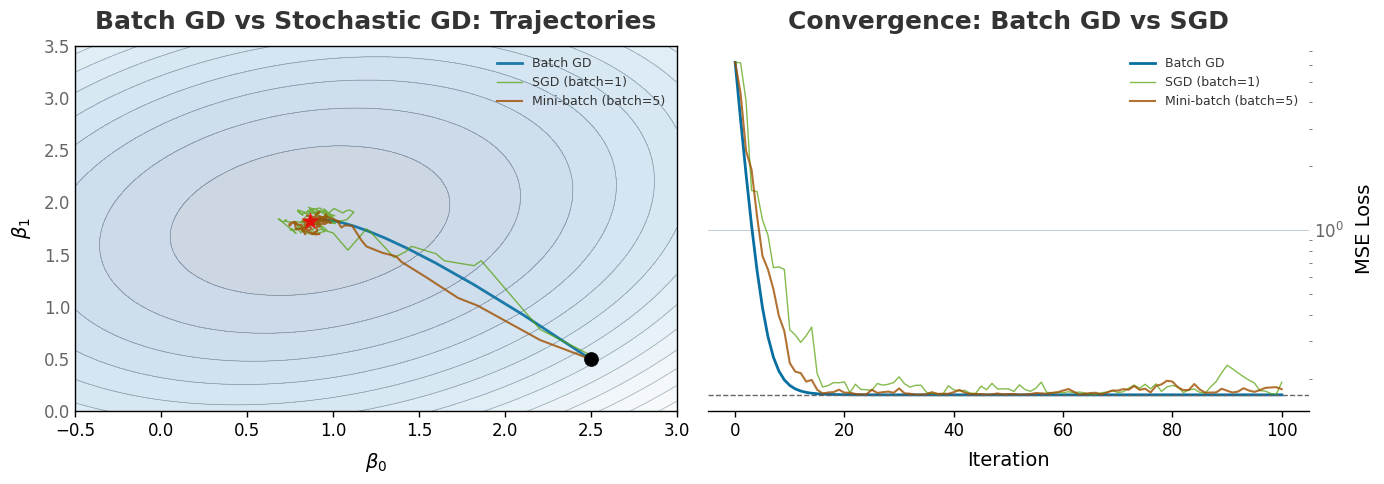

In [10]:
# Compare batch GD vs SGD
np.random.seed(123)
n_iter = 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Trajectories
ax1 = axes[0]
ax1.contour(B0, B1, Loss, levels=15, colors=mt.GRAY, linewidths=0.5, alpha=0.5)
ax1.contourf(B0, B1, Loss, levels=15, cmap='Blues_r', alpha=0.2)

# Batch GD
history_batch, losses_batch = gradient_descent(x, y, 0.1, n_iter, beta_init)
ax1.plot(history_batch[:, 0], history_batch[:, 1], '-', color=mt.BLUE, 
         linewidth=2, label='Batch GD', alpha=0.9)

# SGD with batch_size=1
history_sgd, losses_sgd = sgd(x, y, 0.05, n_iter, beta_init, batch_size=1)
ax1.plot(history_sgd[:, 0], history_sgd[:, 1], '-', color=mt.GREEN, 
         linewidth=1, label='SGD (batch=1)', alpha=0.7)

# Mini-batch SGD
history_mini, losses_mini = sgd(x, y, 0.08, n_iter, beta_init, batch_size=5)
ax1.plot(history_mini[:, 0], history_mini[:, 1], '-', color=mt.ORANGE, 
         linewidth=1.5, label='Mini-batch (batch=5)', alpha=0.8)

ax1.scatter(*beta_init, color='black', s=100, marker='o', zorder=5)
ax1.scatter(*beta_ols, color=mt.RED, s=150, marker='*', zorder=5)

ax1.set_xlabel(r'$\beta_0$')
ax1.set_ylabel(r'$\beta_1$')
ax1.set_title('Batch GD vs Stochastic GD: Trajectories')
ax1.legend(loc='upper right', fontsize=9)
ax1.set_xlim(-0.5, 3)
ax1.set_ylim(0, 3.5)

for spine in ['top', 'right', 'left', 'bottom']:
    ax1.spines[spine].set_visible(True)
    ax1.spines[spine].set_color('black')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position('left')
ax1.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False)
ax1.grid(False)

# Convergence curves
ax2 = axes[1]
ax2.plot(losses_batch, '-', color=mt.BLUE, linewidth=2, label='Batch GD')
ax2.plot(losses_sgd, '-', color=mt.GREEN, linewidth=1, alpha=0.7, label='SGD (batch=1)')
ax2.plot(losses_mini, '-', color=mt.ORANGE, linewidth=1.5, alpha=0.8, label='Mini-batch (batch=5)')
ax2.axhline(y=mse_loss(*beta_ols, x, y), color=mt.GRAY, linestyle='--', linewidth=1)

ax2.set_xlabel('Iteration')
ax2.set_ylabel('MSE Loss')
ax2.set_title('Convergence: Batch GD vs SGD')
ax2.legend(loc='upper right', fontsize=9)
ax2.set_yscale('log')

mt.apply_economist_style(ax2)

plt.tight_layout()
plt.show()

**Key observations**:
- Batch GD follows a smooth, direct path
- SGD follows a noisy, wandering path but still converges
- Mini-batch is a compromise: some noise, but less erratic than pure SGD

## 6. Momentum: The Ball Rolling Downhill

**Momentum** accelerates gradient descent by accumulating a velocity vector:

$$\mathbf{v}^{(t+1)} = \gamma \mathbf{v}^{(t)} + \eta \nabla L(\boldsymbol{\beta}^{(t)})$$
$$\boldsymbol{\beta}^{(t+1)} = \boldsymbol{\beta}^{(t)} - \mathbf{v}^{(t+1)}$$

The momentum term $\gamma$ (typically 0.9) keeps the optimizer moving in consistent directions, dampening oscillations.

In [11]:
def gradient_descent_momentum(x, y, learning_rate, momentum, n_iterations, beta_init):
    """
    Gradient descent with momentum.
    """
    beta = np.array(beta_init, dtype=float)
    velocity = np.zeros(2)
    history = [beta.copy()]
    losses = [mse_loss(beta[0], beta[1], x, y)]
    
    for _ in range(n_iterations):
        grad = gradient(beta[0], beta[1], x, y)
        velocity = momentum * velocity + learning_rate * grad
        beta = beta - velocity
        history.append(beta.copy())
        losses.append(mse_loss(beta[0], beta[1], x, y))
    
    return np.array(history), np.array(losses)

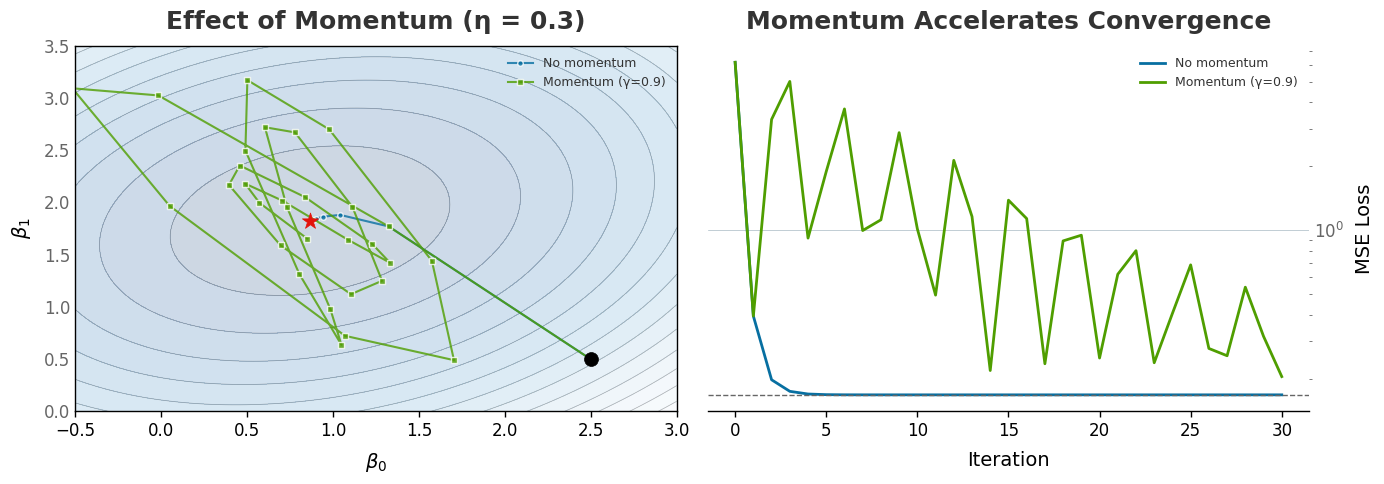

In [12]:
# Compare with and without momentum
# Use a learning rate where vanilla GD oscillates
lr = 0.3
n_iter = 30

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Trajectories
ax1 = axes[0]
ax1.contour(B0, B1, Loss, levels=15, colors=mt.GRAY, linewidths=0.5, alpha=0.5)
ax1.contourf(B0, B1, Loss, levels=15, cmap='Blues_r', alpha=0.2)

# Without momentum
history_no_mom, losses_no_mom = gradient_descent(x, y, lr, n_iter, beta_init)
ax1.plot(history_no_mom[:, 0], history_no_mom[:, 1], 'o-', color=mt.BLUE, 
         markersize=4, linewidth=1.5, label='No momentum', alpha=0.8)

# With momentum
history_mom, losses_mom = gradient_descent_momentum(x, y, lr, 0.9, n_iter, beta_init)
ax1.plot(history_mom[:, 0], history_mom[:, 1], 's-', color=mt.GREEN, 
         markersize=4, linewidth=1.5, label='Momentum (γ=0.9)', alpha=0.8)

ax1.scatter(*beta_init, color='black', s=100, marker='o', zorder=5)
ax1.scatter(*beta_ols, color=mt.RED, s=150, marker='*', zorder=5)

ax1.set_xlabel(r'$\beta_0$')
ax1.set_ylabel(r'$\beta_1$')
ax1.set_title(f'Effect of Momentum (η = {lr})')
ax1.legend(loc='upper right', fontsize=9)
ax1.set_xlim(-0.5, 3)
ax1.set_ylim(0, 3.5)

for spine in ['top', 'right', 'left', 'bottom']:
    ax1.spines[spine].set_visible(True)
    ax1.spines[spine].set_color('black')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position('left')
ax1.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False)
ax1.grid(False)

# Convergence
ax2 = axes[1]
ax2.plot(losses_no_mom, '-', color=mt.BLUE, linewidth=2, label='No momentum')
ax2.plot(losses_mom, '-', color=mt.GREEN, linewidth=2, label='Momentum (γ=0.9)')
ax2.axhline(y=mse_loss(*beta_ols, x, y), color=mt.GRAY, linestyle='--', linewidth=1)

ax2.set_xlabel('Iteration')
ax2.set_ylabel('MSE Loss')
ax2.set_title('Momentum Accelerates Convergence')
ax2.legend(loc='upper right', fontsize=9)
ax2.set_yscale('log')

mt.apply_economist_style(ax2)

plt.tight_layout()
plt.show()

## 7. Visualizing the Gradient

At each point, the gradient vector points in the direction of steepest *ascent*. We move in the opposite direction to descend.

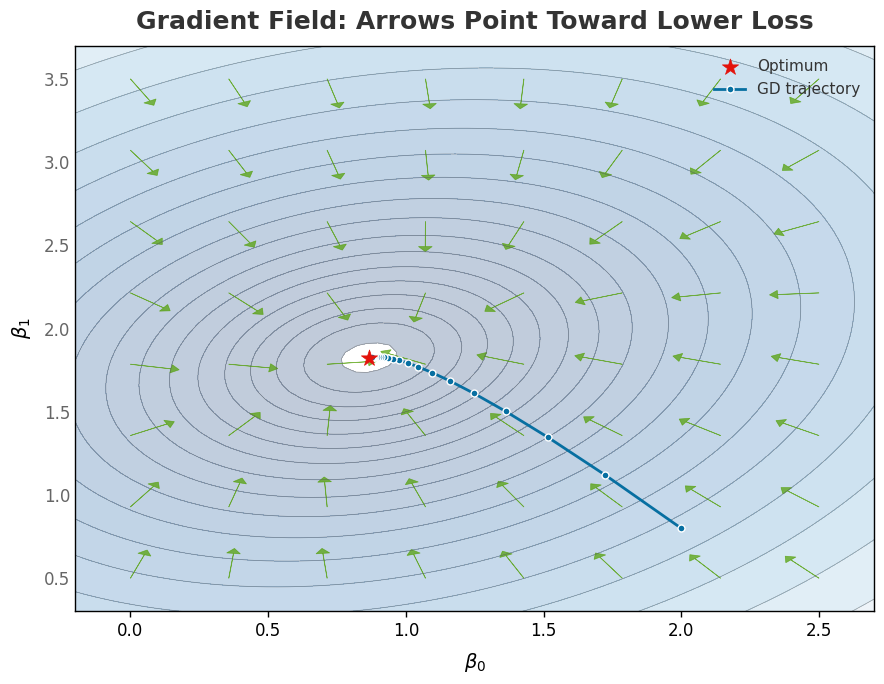

In [13]:
# Create gradient field visualization
fig, ax = plt.subplots(figsize=(9, 7))

# Contours
levels = np.logspace(np.log10(Loss.min() + 0.01), np.log10(Loss.max()), 20)
ax.contour(B0, B1, Loss, levels=levels, colors=mt.GRAY, linewidths=0.5, alpha=0.6)
ax.contourf(B0, B1, Loss, levels=levels, cmap='Blues_r', alpha=0.25)

# Gradient arrows on a grid
b0_arrows = np.linspace(0, 2.5, 8)
b1_arrows = np.linspace(0.5, 3.5, 8)

for b0 in b0_arrows:
    for b1 in b1_arrows:
        grad = gradient(b0, b1, x, y)
        # Scale arrow length for visibility
        grad_norm = np.linalg.norm(grad)
        if grad_norm > 0.1:
            grad_scaled = grad / grad_norm * 0.15  # Fixed length arrows
            # Arrow points in negative gradient direction (descent)
            ax.arrow(b0, b1, -grad_scaled[0], -grad_scaled[1], 
                    head_width=0.05, head_length=0.03, fc=mt.GREEN, ec=mt.GREEN, alpha=0.7)

# Mark optimum
ax.scatter(*beta_ols, color=mt.RED, s=150, marker='*', zorder=5, label='Optimum')

# Add one trajectory
history, _ = gradient_descent(x, y, 0.1, 20, [2.0, 0.8])
ax.plot(history[:, 0], history[:, 1], 'o-', color=mt.BLUE, markersize=5, 
        linewidth=2, label='GD trajectory', zorder=4)

ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')
ax.set_title('Gradient Field: Arrows Point Toward Lower Loss')
ax.legend(loc='upper right')
ax.set_xlim(-0.2, 2.7)
ax.set_ylim(0.3, 3.7)

for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False)
ax.grid(False)

plt.tight_layout()
plt.show()

## 8. Key Takeaways

1. **Gradient descent** iteratively moves parameters in the direction of steepest descent on the loss surface.

2. **Learning rate** is critical:
   - Too small → slow convergence
   - Too large → oscillation or divergence
   - Just right → fast, stable convergence

3. **Stochastic GD** uses random subsets of data, trading computation for noise. The noise can help escape local minima.

4. **Momentum** accumulates velocity, accelerating convergence and dampening oscillations.

5. For **convex** problems like linear regression, gradient descent converges to the global optimum. For **non-convex** problems (neural networks), it may find local minima.

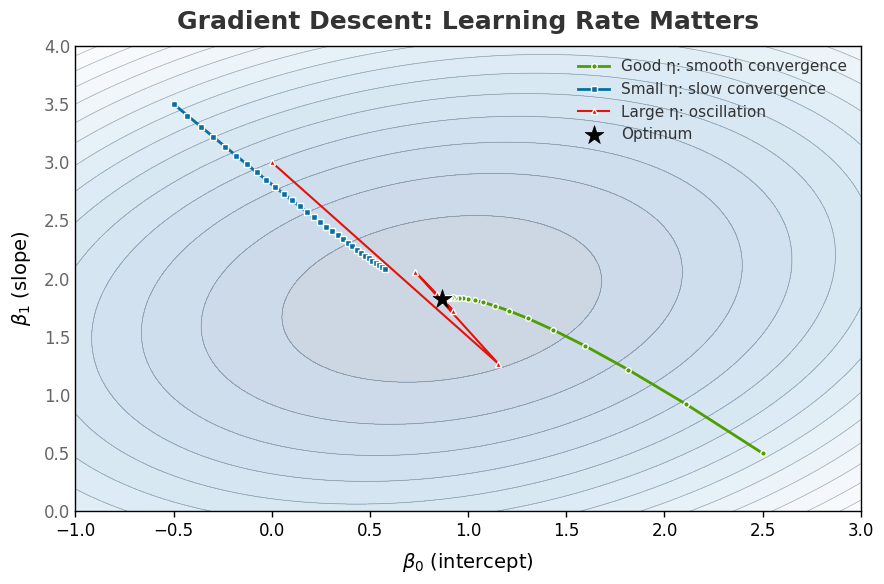

In [14]:
# Summary figure
fig, ax = plt.subplots(figsize=(9, 6))

ax.contour(B0, B1, Loss, levels=15, colors=mt.GRAY, linewidths=0.5, alpha=0.5)
ax.contourf(B0, B1, Loss, levels=15, cmap='Blues_r', alpha=0.2)

# Three trajectories demonstrating key concepts
# 1. Good learning rate
h1, _ = gradient_descent(x, y, 0.1, 30, [2.5, 0.5])
ax.plot(h1[:, 0], h1[:, 1], 'o-', color=mt.GREEN, markersize=4, 
        linewidth=2, label='Good η: smooth convergence')

# 2. Small learning rate (slow)
h2, _ = gradient_descent(x, y, 0.02, 30, [-0.5, 3.5])
ax.plot(h2[:, 0], h2[:, 1], 's-', color=mt.BLUE, markersize=4, 
        linewidth=2, label='Small η: slow convergence')

# 3. Large learning rate (oscillating)
h3, _ = gradient_descent(x, y, 0.5, 30, [0.0, 3.0])
ax.plot(h3[:, 0], h3[:, 1], '^-', color=mt.RED, markersize=4, 
        linewidth=1.5, label='Large η: oscillation')

ax.scatter(*beta_ols, color='black', s=200, marker='*', zorder=5, label='Optimum')

ax.set_xlabel(r'$\beta_0$ (intercept)')
ax.set_ylabel(r'$\beta_1$ (slope)')
ax.set_title('Gradient Descent: Learning Rate Matters')
ax.legend(loc='upper right')
ax.set_xlim(-1, 3)
ax.set_ylim(0, 4)

for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False)
ax.grid(False)

plt.tight_layout()
plt.show()